In [42]:
# !pip install mplfinance
# !pip install yfinance

In [43]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
from itertools import product


In [44]:
def MACD(df, window_fast, window_slow, window_signal):
    price = df['Close']
    ema_fast = price.ewm(span=window_fast, adjust=False, min_periods=window_fast).mean()
    ema_slow = price.ewm(span=window_slow, adjust=False, min_periods=window_slow).mean()
    macd_line = ema_fast - ema_slow                      # 표준 정의
    signal    = macd_line.ewm(span=window_signal, adjust=False, min_periods=window_signal).mean()
    diff      = macd_line - signal
    out = pd.DataFrame({
        'ema_fast': ema_fast, 'ema_slow': ema_slow,
        'macd': macd_line, 'signal': signal, 'diff': diff,
        'bar_positive': diff.where(diff > 0, 0.0),
        'bar_negative': diff.where(diff < 0, 0.0),
    })
    return out


In [45]:
class CustomTimeSeriesSplit:
    """
    워크-포워드 split
    - n_splits: 분할 개수
    - test_size: 각 폴드의 테스트 길이(없으면 n_samples //(n_splits+1) 로 자동결정)
    - gap: train과 test 사이의 비워두는 구간(정보누설 방지용)
    - max_train_size: 학습창 상한(롤링창처럼 쓰고 싶을 때 지정; None이면 확장형 창)
    """
    def __init__(self, n_splits=5, test_size=None, gap=0, max_train_size=None):
        self.n_splits = int(n_splits)
        self.test_size = None if test_size is None else int(test_size)
        self.gap = int(gap)
        self.max_train_size = None if max_train_size is None else int(max_train_size)

    def split(self, X):
        n_samples = len(X)
        if self.n_splits < 1:
            raise ValueError("n_splits must be >= 1")

        # test_size가 None이면 균등 폴드 크기 사용
        test_size = self.test_size
        if test_size is None:
            test_size = n_samples // (self.n_splits + 1)
            if test_size < 1:
                raise ValueError("Too few samples for given n_splits.")

        for i in range(self.n_splits):
            # 학습 구간 끝(확장형): 매 폴드마다 test_size만큼 전진
            train_end = (i + 1) * test_size
            test_start = train_end + self.gap
            test_end = test_start + test_size

            if test_end > n_samples:
                break  # 남은 데이터가 부족하면 중단

            if self.max_train_size is None:
                train_start = 0  # 확장형(anchored expanding)
            else:
                train_start = max(0, train_end - self.max_train_size)  # 롤링 상한

            train_idx = np.arange(train_start, train_end, dtype=int)
            test_idx = np.arange(test_start, test_end, dtype=int)
            yield train_idx, test_idx

In [46]:
def simulate_strategy(df, macd_line, signal_line):
    """Simulates a simple MACD crossover strategy and returns the cumulative return."""
    # 'position' column: 1 indicates a "buy" or "hold" position, 0 indicates no position.
    # A position is taken when the MACD line is above the signal line.
    df['position'] = np.where(macd_line > signal_line, 1, 0)
    # 'returns' column: Calculate the daily percentage change in closing price.
    df['returns'] = df['Close'].pct_change()
    # 'strategy_returns': Calculate the returns based on our strategy.
    # We use .shift(1) because we make a buy/sell decision based on the previous day's signal.
    df['strategy_returns'] = df['position'].shift(1) * df['returns']
    # Calculate and return the final cumulative product of the strategy returns.
    # This represents the total growth of an initial investment of 1.
    return (1 + df['strategy_returns']).cumprod().iloc[-1]

def create_params_combinations():
    # Define the parameter grid for validation
    param_grid = {
        'window_fast': [10, 12, 15],
        'window_slow': [20, 26, 30],
        'window_signal': [7, 9, 12]
    }
    return list(product(*param_grid.values()))

def grid_search_params(df, param_combinations):
    # Time Series Cross Validation
    tscv = CustomTimeSeriesSplit(n_splits=5, test_size=63, gap=5, max_train_size=None)

    results = []

    # Run the cross-validation loop
    for params in param_combinations:
        fast, slow, signal = params

        # slow is larger than fast
        if slow <= fast:
            continue

        fold_returns = []
        for train_index, test_index in tscv.split(df):
            # Train and Test data spilt
            train_df = df.iloc[train_index]
            test_df = df.iloc[test_index]

            # Calc MACD using train data
            macd_train = MACD(train_df, fast, slow, signal)


            # Calc MACD at Test data (Assume data is coming)
            full_period_df = pd.concat([train_df, test_df])
            macd_test = MACD(full_period_df, fast, slow, signal)

            # Choose test MACD
            test_macd = macd_test['macd'].iloc[len(train_df):]
            test_signal = macd_test['signal'].iloc[len(train_df):]

            # simulation using test data
            fold_return = simulate_strategy(test_df.copy(), test_macd, test_signal)
            fold_returns.append(fold_return)

        # Calc average return
        avg_return = np.mean(fold_returns)
        results.append({
            'params': params,
            'avg_return': avg_return
        })
    return results

In [47]:
# Golden Cross & Dead Cross 분석 함수
def analyze_golden_dead_cross(df, short_window=20, long_window=60):
    """
    Golden Cross와 Dead Cross 분석
    - Golden Cross: 단기 이동평균이 장기 이동평균을 상향 돌파
    - Dead Cross: 단기 이동평균이 장기 이동평균을 하향 돌파
    """
    # 이동평균 계산
    df["MA_short"] = df["Close"].rolling(window=short_window).mean()
    df["MA_long"] = df["Close"].rolling(window=long_window).mean()

    # 교차 신호 생성
    df["MA_diff"] = df["MA_short"] - df["MA_long"]
    df["MA_diff_prev"] = df["MA_diff"].shift(1)

    # Golden Cross: 이전에는 음수, 현재는 양수
    df["Golden_Cross"] = (df["MA_diff"] > 0) & (df["MA_diff_prev"] <= 0)
    # Dead Cross: 이전에는 양수, 현재는 음수
    df["Dead_Cross"] = (df["MA_diff"] < 0) & (df["MA_diff_prev"] >= 0)

    return df

# 1. MSFT 종목 분석

In [48]:
TICKER = "MSFT"
df = yf.download(TICKER,
                 start="2023-01-01",
                 end="2024-12-31",
                 auto_adjust=True)

print('\n Microsoft \n', df)
print('Multi colums: \n', df.columns)

[*********************100%***********************]  1 of 1 completed


 Microsoft 
 Price            Close        High         Low        Open    Volume
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT
Date                                                                
2023-01-03  234.423584  240.460787  232.290496  237.848254  25740000
2023-01-04  224.169144  227.857992  221.096726  227.280694  50623400
2023-01-05  217.525269  222.652495  216.987103  222.310022  39585600
2023-01-06  220.088882  220.901020  214.628992  218.200429  43613600
2023-01-09  222.231735  226.263071  221.537025  221.576157  27369800
...                ...         ...         ...         ...       ...
2024-12-23  432.871429  435.258308  430.464641  434.353277  19152500
2024-12-24  436.929108  437.197652  431.817213  432.274691   7164500
2024-12-26  435.715790  438.530341  434.243897  436.680490   8194200
2024-12-27  428.177216  432.841588  424.020066  432.224981  18117700
2024-12-30  422.508331  425.213468  419.594351  423.731620  13158700

[501 rows x 5 colum

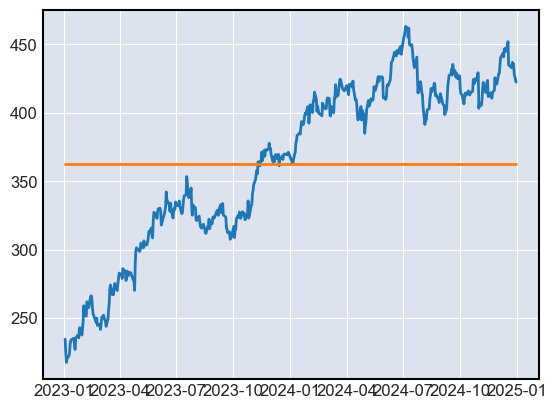

In [49]:
X = df.index
Y = [df['Close'].mean()] * len(X)

plt.plot(X, df['Close'])
plt.plot(X, Y)

In [50]:
df.columns = df.columns.droplevel('Ticker')

MSFT_px = df['Close']

MSFT_px

Date
2023-01-03    234.423584
2023-01-04    224.169144
2023-01-05    217.525269
2023-01-06    220.088882
2023-01-09    222.231735
                 ...    
2024-12-23    432.871429
2024-12-24    436.929108
2024-12-26    435.715790
2024-12-27    428.177216
2024-12-30    422.508331
Name: Close, Length: 501, dtype: float64

### 1-1. EMA 그리기

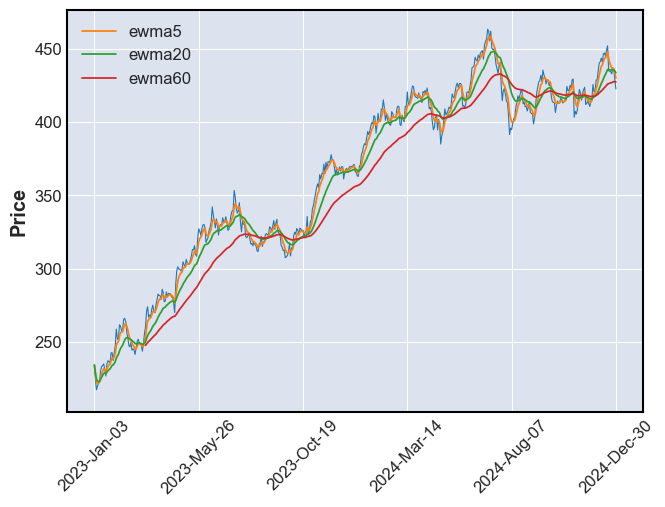

In [51]:
# 5-day, 20-day, 60-day moving average of MSFT stock price with exponential weighting
# alpha = 2 / (span +1) for span >= 1

ewma5 = MSFT_px.ewm(span=5).mean() # 5-day ema
ewma20 = MSFT_px.ewm(span=20).mean() # 20-day ema
ewma60 = MSFT_px.ewm(span=60, min_periods=50).mean() # 60-day ema

sma60 = MSFT_px.rolling(window=60, min_periods=50).mean()
apds = [
        mpf.make_addplot(ewma5, label='ewma5'),
        mpf.make_addplot(ewma20, label='ewma20'),
        mpf.make_addplot(ewma60, label='ewma60')]

mpf.plot(df,
        type="line",
        # mav=[5, 20, 60],
        addplot=apds,
        volume=False)

### 1-2. MACD 분석

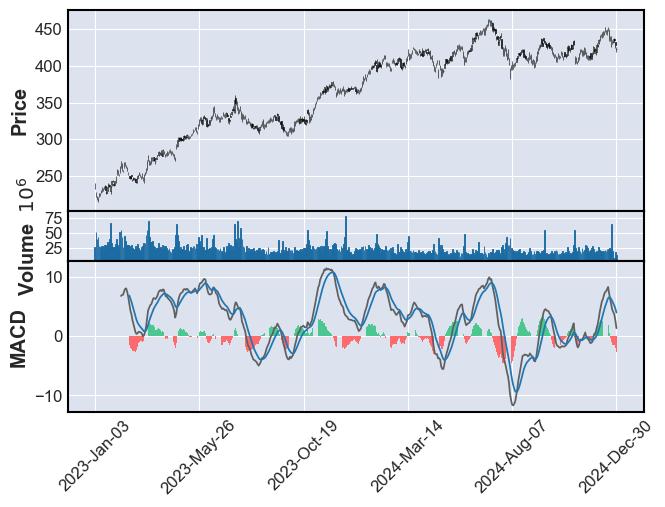

In [52]:
# 표준 파라미터
macd = MACD(df, 12, 26, 9)
macd_plot = [
    mpf.make_addplot((macd['macd']), color='#606060', panel=2, ylabel='MACD', secondary_y=False),
    mpf.make_addplot((macd['signal']), color='#1f77b4', panel=2, secondary_y=False),
    mpf.make_addplot((macd['bar_positive']), type='bar', color='#4dc790', panel=2),
    mpf.make_addplot((macd['bar_negative']), type='bar', color='#fd6b6c', panel=2)
]

mpf.plot(df, type='candle', volume=True, addplot=macd_plot, panel_ratios=(4,1,3))

In [53]:
# Time-series Cross Validation

# Create all parameter combinations from the grid
param_combinations = create_params_combinations()

results = grid_search_params(df, param_combinations)

# Result Analysis
results_df = pd.DataFrame(results).sort_values(by='avg_return', ascending=False)

print("--- 최적 MACD 파라미터 검증 결과 (평균 누적수익률 기준) ---")
print(results_df.head())

print(f"\n표준 파라미터 (12, 26, 9)의 결과:")
print(results_df[results_df['params'] == (12, 26, 9)])

--- 최적 MACD 파라미터 검증 결과 (평균 누적수익률 기준) ---
         params  avg_return
6   (10, 30, 7)    1.045750
12  (12, 26, 7)    1.040609
9   (12, 20, 7)    1.039477
1   (10, 20, 9)    1.038878
3   (10, 26, 7)    1.038752

표준 파라미터 (12, 26, 9)의 결과:
         params  avg_return
13  (12, 26, 9)    1.022521


### 1-3. Golden Cross & Dead Cross 분석

=== MSFT Golden Cross & Dead Cross 분석 ===
Golden Cross 발생 횟수: 5
Dead Cross 발생 횟수: 5

Golden Cross 발생 날짜:
  2023-10-25: 가격 335.61
  2024-05-28: 가격 426.35
  2024-10-01: 가격 417.56
  2024-11-12: 가격 419.88
  2024-12-05: 가격 440.20

Dead Cross 발생 날짜:
  2023-08-15: 가격 316.41
  2024-04-30: 가격 385.04
  2024-08-06: 가격 395.92
  2024-11-01: 가격 407.31
  2024-11-20: 가격 412.39


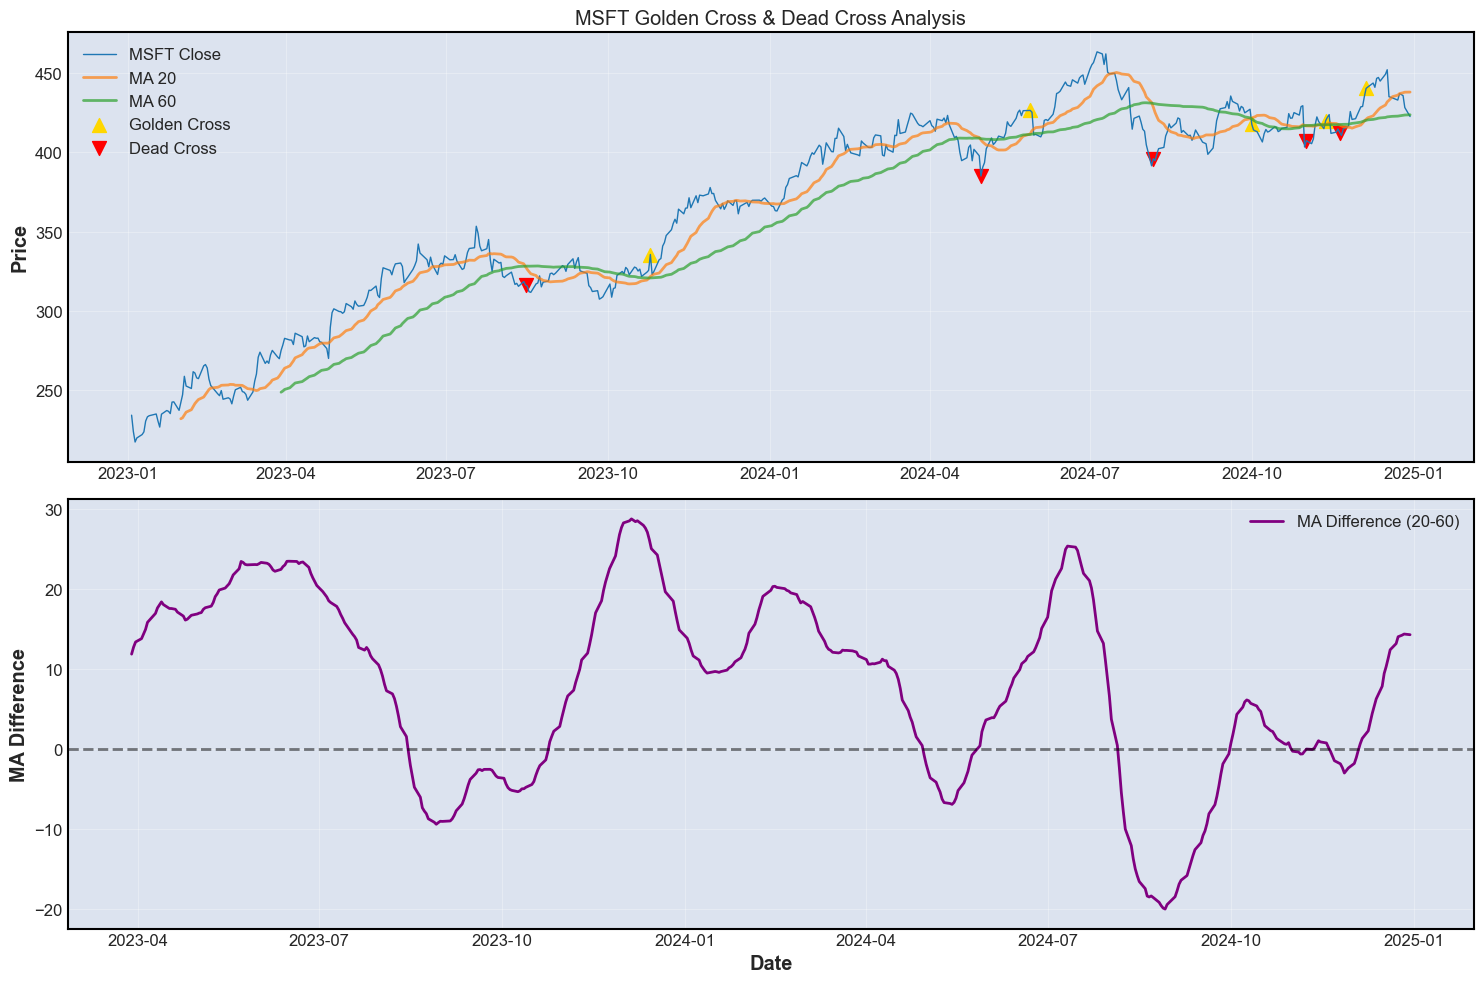

In [54]:
# MSFT Golden Cross & Dead Cross 분석
msft_analysis = analyze_golden_dead_cross(df, 20, 60)

# Golden Cross와 Dead Cross 발생 시점 찾기
msft_golden_cross_dates = msft_analysis[msft_analysis["Golden_Cross"]].index
msft_dead_cross_dates = msft_analysis[msft_analysis["Dead_Cross"]].index

print("=== MSFT Golden Cross & Dead Cross 분석 ===")
print(f"Golden Cross 발생 횟수: {len(msft_golden_cross_dates)}")
print(f"Dead Cross 발생 횟수: {len(msft_dead_cross_dates)}")

if len(msft_golden_cross_dates) > 0:
    print(f"\nGolden Cross 발생 날짜:")
    for date in msft_golden_cross_dates:
        print(
            f"  {date.strftime('%Y-%m-%d')}: 가격 {msft_analysis.loc[date, 'Close']:.2f}"
        )

if len(msft_dead_cross_dates) > 0:
    print(f"\nDead Cross 발생 날짜:")
    for date in msft_dead_cross_dates:
        print(
            f"  {date.strftime('%Y-%m-%d')}: 가격 {msft_analysis.loc[date, 'Close']:.2f}"
        )

# 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# 첫 번째 차트: 가격과 이동평균
ax1.plot(msft_analysis.index, msft_analysis["Close"], label="MSFT Close", linewidth=1)
ax1.plot(msft_analysis.index, msft_analysis["MA_short"], label=f"MA {20}", alpha=0.7)
ax1.plot(msft_analysis.index, msft_analysis["MA_long"], label=f"MA {60}", alpha=0.7)

# Golden Cross 표시
for date in msft_golden_cross_dates:
    ax1.scatter(
        date,
        msft_analysis.loc[date, "Close"],
        color="gold",
        s=100,
        marker="^",
        label="Golden Cross" if date == msft_golden_cross_dates[0] else "",
    )

# Dead Cross 표시
for date in msft_dead_cross_dates:
    ax1.scatter(
        date,
        msft_analysis.loc[date, "Close"],
        color="red",
        s=100,
        marker="v",
        label="Dead Cross" if date == msft_dead_cross_dates[0] else "",
    )

ax1.set_title("MSFT Golden Cross & Dead Cross Analysis")
ax1.set_ylabel("Price")
ax1.legend()
ax1.grid(True, alpha=0.3)

# 두 번째 차트: 이동평균 차이
ax2.plot(
    msft_analysis.index,
    msft_analysis["MA_diff"],
    label="MA Difference (20-60)",
    color="purple",
)
ax2.axhline(y=0, color="black", linestyle="--", alpha=0.5)
ax2.set_ylabel("MA Difference")
ax2.set_xlabel("Date")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. S&P 500(SPY) 분석

In [55]:
TICKER = "SPY"
df = yf.download(TICKER,
                 start="2023-01-01",
                 end="2024-12-31",
                 auto_adjust=True)

print('\n SPY 201 \n', df)
print('Multi colums: \n', df.columns)

[*********************100%***********************]  1 of 1 completed


 SPY 201 
 Price            Close        High         Low        Open     Volume
Ticker             SPY         SPY         SPY         SPY        SPY
Date                                                                 
2023-01-03  368.168701  373.592316  365.278013  371.600754   74850700
2023-01-04  371.011017  373.060583  367.375919  370.450269   85934100
2023-01-05  366.776550  369.154818  366.177152  369.038809   76970500
2023-01-06  375.187469  376.318614  366.805515  369.899189  104189600
2023-01-09  374.974792  380.620806  374.791132  377.401417   73978100
...                ...         ...         ...         ...        ...
2024-12-23  591.158813  591.765177  584.170528  587.381389   57635800
2024-12-24  597.729492  597.769293  591.934094  592.520617   33160100
2024-12-26  597.769348  598.902533  594.528696  595.940247   41219100
2024-12-27  591.476868  594.230439  587.252104  593.991813   64969300
2024-12-30  584.727173  588.226291  580.939799  584.399176   56578800

[501 ro

In [56]:
df.columns = df.columns.droplevel('Ticker')

SPY_px = df['Close']

### 2-1. EMA 그리기

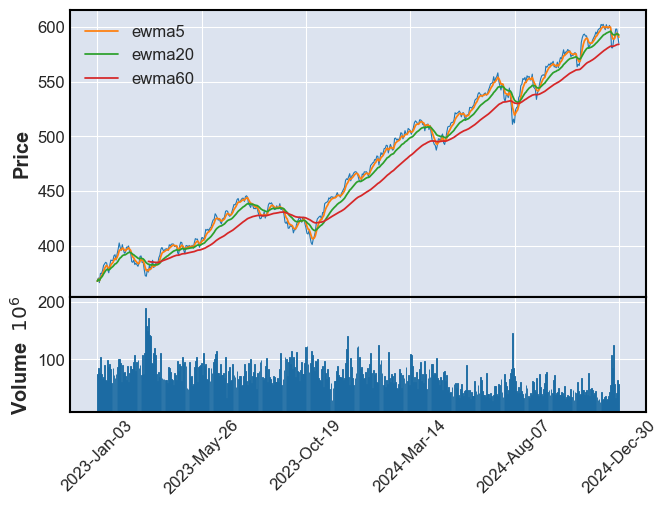

In [57]:
# 5-day, 20-day, 60-day moving average of SPY stock price with exponential weighting

ewma5 = SPY_px.ewm(span=5).mean() # 5-day ema
ewma20 = SPY_px.ewm(span=20).mean() # 20-day ema
ewma60 = SPY_px.ewm(span=60, min_periods=50).mean() # 60-day ema

sma60 = SPY_px.rolling(window=60, min_periods=50).mean()

apds = [
        mpf.make_addplot(ewma5, label='ewma5'),
        mpf.make_addplot(ewma20, label='ewma20'),
        mpf.make_addplot(ewma60, label='ewma60')]

mpf.plot(df,
        type="line",
        # mav=[5, 20, 60],
        addplot=apds,
        volume=True)


### 2-2. MACD 분석

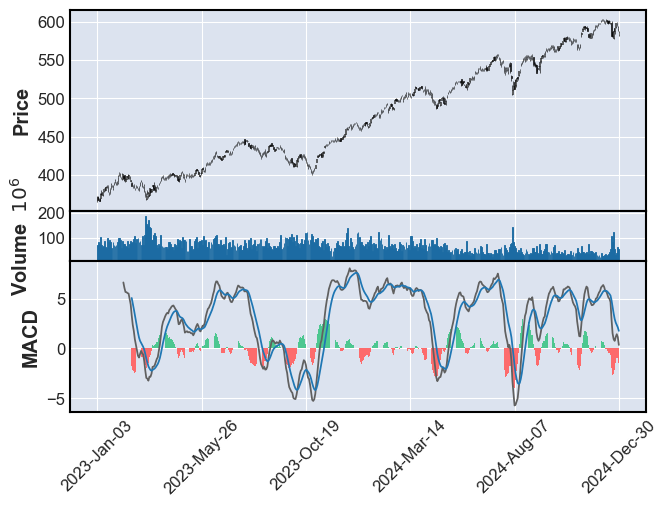

In [58]:
# 표준 파라미터
macd = MACD(df, 12, 26, 9)
macd_plot = [
    mpf.make_addplot((macd['macd']), color='#606060', panel=2, ylabel='MACD', secondary_y=False),
    mpf.make_addplot((macd['signal']), color='#1f77b4', panel=2, secondary_y=False),
    mpf.make_addplot((macd['bar_positive']), type='bar', color='#4dc790', panel=2),
    mpf.make_addplot((macd['bar_negative']), type='bar', color='#fd6b6c', panel=2)
]

mpf.plot(df, type='candle', volume=True, addplot=macd_plot, panel_ratios=(4,1,3))

In [59]:
# Time-series Cross Validation

# Create all parameter combinations from the grid
param_combinations = create_params_combinations()

results = grid_search_params(df, param_combinations)

# Result Analysis
results_df = pd.DataFrame(results).sort_values(by='avg_return', ascending=False)

print("--- 최적 MACD 파라미터 검증 결과 (평균 누적수익률 기준) ---")
print(results_df.head())

print(f"\n표준 파라미터 (12, 26, 9)의 결과:")
print(results_df[results_df['params'] == (12, 26, 9)])

--- 최적 MACD 파라미터 검증 결과 (평균 누적수익률 기준) ---
          params  avg_return
0    (10, 20, 7)    1.028791
26  (15, 30, 12)    1.027437
3    (10, 26, 7)    1.022230
9    (12, 20, 7)    1.021430
23  (15, 26, 12)    1.021318

표준 파라미터 (12, 26, 9)의 결과:
         params  avg_return
13  (12, 26, 9)     1.01495


### 2-3. Golden Cross & Dead Cross 분석

=== SPY Golden Cross & Dead Cross 분석 ===
Golden Cross 발생 횟수: 4
Dead Cross 발생 횟수: 3

Golden Cross 발생 날짜:
  2023-04-12: 가격 396.00
  2023-11-22: 가격 444.79
  2024-05-17: 가격 521.26
  2024-08-30: 가격 556.75

Dead Cross 발생 날짜:
  2023-09-05: 가격 437.59
  2024-05-01: 가격 492.61
  2024-08-13: 가격 535.37


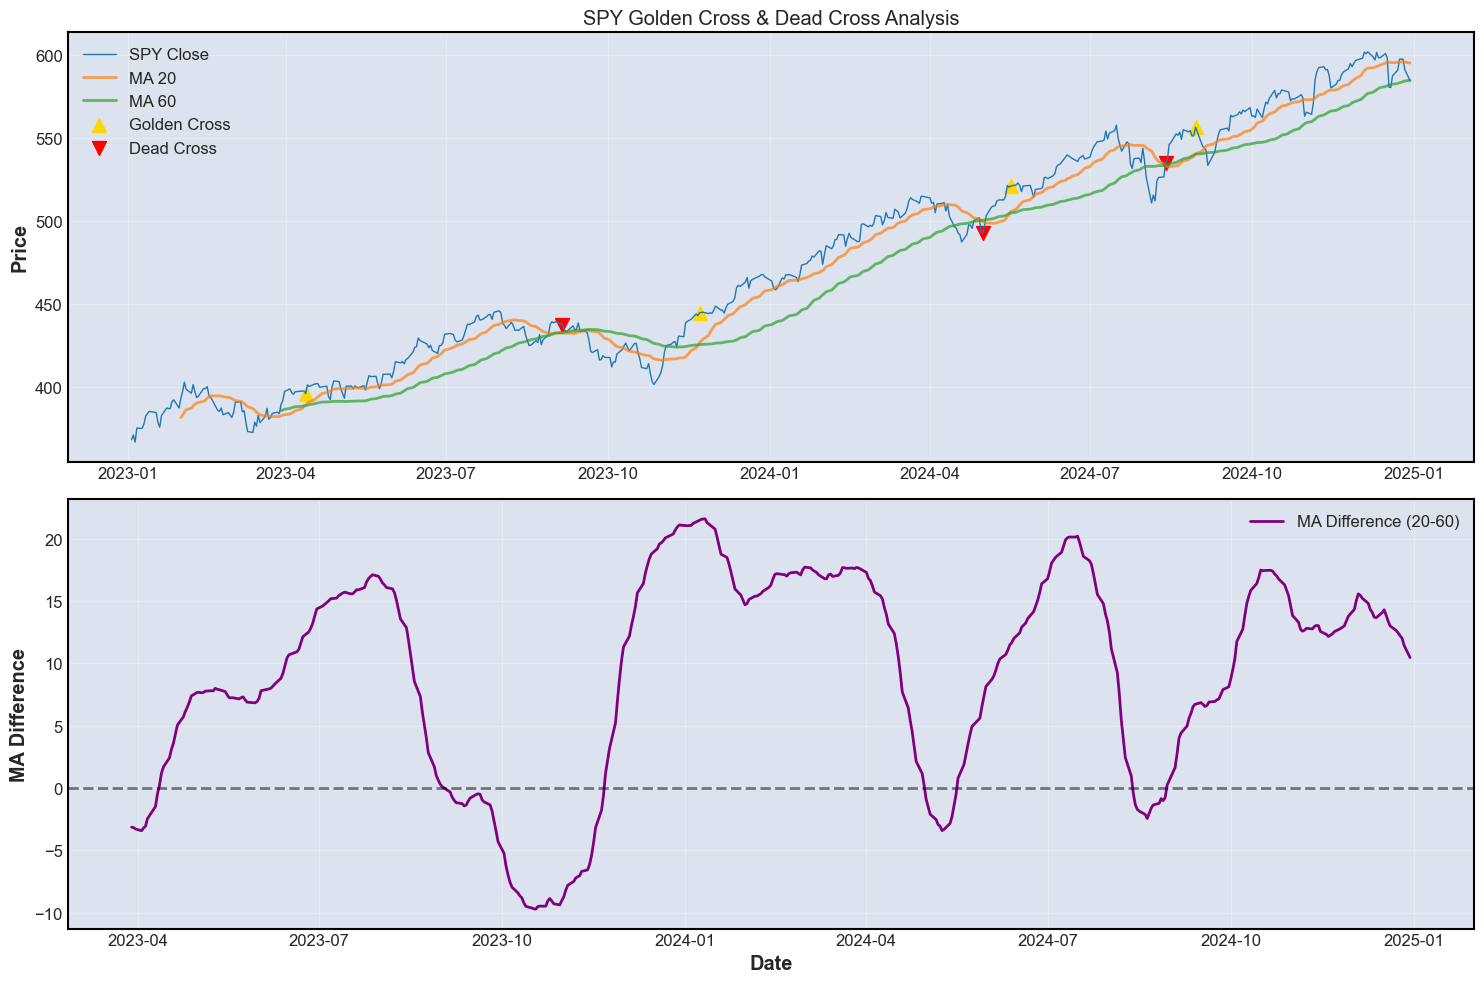

In [60]:
# SPY Golden Cross & Dead Cross 분석
spy_analysis = analyze_golden_dead_cross(df, 20, 60)

# Golden Cross와 Dead Cross 발생 시점 찾기
golden_cross_dates = spy_analysis[spy_analysis['Golden_Cross']].index
dead_cross_dates = spy_analysis[spy_analysis['Dead_Cross']].index

print("=== SPY Golden Cross & Dead Cross 분석 ===")
print(f"Golden Cross 발생 횟수: {len(golden_cross_dates)}")
print(f"Dead Cross 발생 횟수: {len(dead_cross_dates)}")

if len(golden_cross_dates) > 0:
    print(f"\nGolden Cross 발생 날짜:")
    for date in golden_cross_dates:
        print(f"  {date.strftime('%Y-%m-%d')}: 가격 {spy_analysis.loc[date, 'Close']:.2f}")

if len(dead_cross_dates) > 0:
    print(f"\nDead Cross 발생 날짜:")
    for date in dead_cross_dates:
        print(f"  {date.strftime('%Y-%m-%d')}: 가격 {spy_analysis.loc[date, 'Close']:.2f}")

# 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# 첫 번째 차트: 가격과 이동평균
ax1.plot(spy_analysis.index, spy_analysis['Close'], label='SPY Close', linewidth=1)
ax1.plot(spy_analysis.index, spy_analysis['MA_short'], label=f'MA {20}', alpha=0.7)
ax1.plot(spy_analysis.index, spy_analysis['MA_long'], label=f'MA {60}', alpha=0.7)

# Golden Cross 표시
for date in golden_cross_dates:
    ax1.scatter(date, spy_analysis.loc[date, 'Close'], color='gold', s=100, marker='^', 
                label='Golden Cross' if date == golden_cross_dates[0] else "")

# Dead Cross 표시
for date in dead_cross_dates:
    ax1.scatter(date, spy_analysis.loc[date, 'Close'], color='red', s=100, marker='v',
                label='Dead Cross' if date == dead_cross_dates[0] else "")

ax1.set_title('SPY Golden Cross & Dead Cross Analysis')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 두 번째 차트: 이동평균 차이
ax2.plot(spy_analysis.index, spy_analysis['MA_diff'], label='MA Difference (20-60)', color='purple')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_ylabel('MA Difference')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
